# Tasks (100 pts)
1  There may be anomalies in the data that you may need to factor in before you start on the other tasks. Clean the data first to handle these issues. Explain what you did to clean the data (in bulleted form). (10 pt)


2 Compute the Pearson correlation between the following: (9 pt)

> a. Euclidean distance of the ride and the taxi fare

> b. time of day and distance traveled

> c. time of day and the taxi fare

Which has the highest correlation?

3 For each subtask of (2), create a plot visualizing the relation between the variables.

Comment on whether you see non-linear or any other interesting relations. (9 pt)

4 Create an exciting plot of your own using the dataset that you think reveals something

very interesting. Explain what it is, and anything else you learned. (15 pt)

5 Generate additional features like those from (2) from the given data set. What additional

features can you create? (10 pt)

6 Set up a simple linear regression model to predict taxi fare. Use your generated features

from the previous task if applicable. How well/badly does it work? What are the
coefficients for your features? Which variable(s) are the most important one? (12 pt)

7 Consider external datasets that may be helpful to expand your feature set. Give bullet points explaining all the datasets you could identify that would help improve your predictions. If possible, try finding such datasets online to incorporate into your training.

List any that you were able to use in your analysis. (10 pt)

8 Now, try to build a better prediction model that works harder to solve the task. Perhaps it

will still use linear regression but with new features. Perhaps it will preprocess features better (e.g. normalize or scale the input vector, convert non-numerical value into float, or do a special treatment of missing values). Perhaps it will use a different machine learning approach (e.g. nearest neighbors, random forests, etc). Briefly explain what you did differently here versus the simple model. Which of your models minimizes the squared error? (10 pt)

9 Predict all the taxi fares for instances at file “sample_submission.csv”. Write the result into a csv file and submit it to the website. You should do this for every model you develop. Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. (15 pt)


In [4]:
# Data processing
import pandas as pd
import numpy as np
import datetime as dt

# Geocoding
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import geodesic as geodesic

# Visualization
import seaborn as sb
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Control Variables

In [2]:
PATH = "./all/"
ROWS = 600_000 # read whole file use None
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
LEFT_BOTTOM_CITY = 'Tennessee'
RIGHT_TOP_CITY = 'Maine'
JFK_LONGITUDE = (-73.789185, -73.775291)
JFK_LATITUDE = (40.641960, 40.649562)

# Taxicab Rate of Fare

In [3]:
MILEAGE = 0.4 * 5

# Auxiliary Functions

In [50]:
from math import sin, cos, sqrt, atan2, radians

def dist(row_data):
    R = 6373.0
    s_lon = radians(row_data['pickup_longitude'])
    s_lat = radians(row_data['pickup_latitude'])
    e_lon = radians(row_data['dropoff_longitude'])
    e_lat = radians(row_data['dropoff_latitude'])
    diff_lon = e_lon - s_lon
    diff_lat = e_lat - s_lat

    a = sin(diff_lat / 2)**2 + cos(s_lat) * cos(e_lat) * sin(diff_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c * 0.621371

def dist_by_geopy(row_data):
    s_lon = row_data['pickup_longitude']
    s_lat = row_data['pickup_latitude']
    e_lon = row_data['dropoff_longitude']
    e_lat = row_data['dropoff_latitude']
    return geodesic((s_lon, s_lat), (e_lon, e_lat)).miles

# clean_data['dist'] = np.vectorize(dist)(clean_data['pickup_longitude'], clean_data['pickup_latitude'], clean_data['dropoff_longitude'], clean_data['dropoff_latitude'])
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude/19412565

def possible_transport_region(row_data):
    
    pass

def least_fare_by_distance(row_data):
    
    fare = row_data['fare_amount']
    least_dist = row_data['dist']
    
    return fare >= least_dist * MILEAGE + 2.5

def to_jfk(row_data):
    return (row_data['dropoff_longitude'] >= JFK_LONGITUDE[0]) & \
           (row_data['dropoff_longitude'] <= JFK_LONGITUDE[1]) & \
           (row_data['dropoff_latitude'] >= JFK_LATITUDE[0]) & \
           (row_data['dropoff_latitude'] <= JFK_LATITUDE[1])

def remove_outliers_Tukey(usefulData, attr):
    thirdQuartile = usefulData.quantile(.75)[attr]
    firstQuartile = usefulData.quantile(.25)[attr]
    IQR = thirdQuartile - firstQuartile
    return usefulData[usefulData[attr].between(firstQuartile - (IQR * 1.5), thirdQuartile + (IQR * 1.5))]


# def datetime_parser(x):
#     print(x['pickup_datetime'])
#     try:
#         datetime_object = datetime.strptime(x['pickup_datetime'], '%Y-%m-%d %H:%M:%S')
#         return datetime_object.hours*60 + datetime_object.minutes
#     except:
#         return pd.NaT

# Adjust Fare Amout By Rules (http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml)
```
Metered Fare Information
Onscreen rate is ‘Rate #01 – Standard City Rate.’
The initial charge is $2.50.
Plus 50 cents per 1/5 mile or 50 cents per 60 seconds in slow traffic or when the vehicle is stopped.
In moving traffic on Manhattan streets, the meter should “click” approximately every four downtown blocks, or one block going cross-town (East-West).
There is a 50-cent MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
There is a 30-cent Improvement Surcharge. 
There is a daily 50-cent surcharge from 8pm to 6am.
There is a $1 surcharge from 4pm to 8pm on weekdays, excluding holidays.
Passengers must pay all bridge and tunnel tolls.
Your receipt will show your total fare including tolls. Please take your receipt.
The driver is not required to accept bills over $20.
Please tip your driver for safety and good service.
There are no charges for extra passengers or bags.

To/From JFK and any location in Manhattan:
Onscreen rate is ‘Rate #02 – JFK Airport.’
This is a flat fare of $52 plus tolls, the 50-cent MTA State Surcharge, the 30-cent Improvement Surcharge, and $4.50 rush hour surcharge (4 PM to 8 PM weekdays, excluding legal holidays).
Passenger is responsible for paying all tolls.
Please tip your driver for safety and good service.
```

In [ ]:
def adjust_fare(row_data):
    fare = row_data['fare_amount']
    
    if to_jfk(row_data) or from:
        # flat fare of $52
        fare -= 52
        # MTA State Surcharge
        fare -= 0.5
        # 30-cent Improvement Surcharge,
        fare -= 0.3
        
        if is_rush(row_data):
            fare -= 4.5
    # from_jfk to maha
        

# Get Data & Transform UTC to EST or EDT

In [5]:
train_df = pd.read_csv(PATH + TRAIN_FILE, nrows = ROWS)
test_df = pd.read_csv(PATH + TEST_FILE)

In [6]:
train_df['pickup_datetime'] = pd.to_datetime(train_df.pickup_datetime, infer_datetime_format=True)
train_df.insert(train_df.shape[1],\
                'new_york_time', \
                train_df.pickup_datetime.\
                dt.tz_localize('utc').\
                dt.tz_convert('America/New_York'))

In [8]:
train_df.head()
# print(train_df.new_york_time.loc[0].hour)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_york_time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21-04:00
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 11:52:16-05:00
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-17 20:35:00-04:00
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 00:30:42-04:00
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 02:51:00-05:00


# Q1 Take a look at the training data ...

## There may be anomalies in the data that you may need to factor in before you start on the other tasks. Clean the data first to handle these issues. Explain what you did to clean the data (in bulleted form).

# Data Cleaning

## Remove trivial anomaly as follows:
* data['fare_amount'] <= 2.5
* data['longitude'] >= -69.445473 or data['longitude'] <= -86.580444
* data['latitude'] <= 35.517490 or data['latitude'] >= 45.253784
* pickup location == dropoff location
* data['passenger_count'] < 0 or data['passenger_count'] > 6

>[How many people can fit into a yellow taxicab?](#http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml)

> From Driver Rule 54-15(g) (in PDF):
The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.

In [9]:
print('Original size:', train_df.shape[0])
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size:', train_df.shape[0])

Original size: 554253
New size: 554247


In [10]:
test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime, infer_datetime_format=True)

In [11]:
print('Before data cleaning:')
df = train_df[:]
df.describe()

Before data cleaning:


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,554247.000000,554247.000000,554247.000000,554247.000000,554247.000000,554247.000000
mean,11.348476,-72.528619,39.922797,-72.525550,39.918447,1.683847
std,9.880137,12.528707,7.939323,11.679850,7.289806,1.307555
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992045,40.734947,-73.991388,40.734062,1.000000
50%,8.500000,-73.981792,40.752683,-73.980141,40.753140,1.000000
75%,12.500000,-73.967110,40.767090,-73.963598,40.768127,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [12]:
geolocator = geopy.Nominatim(user_agent='boundary')
left_bottom_boundary = geolocator.geocode(LEFT_BOTTOM_CITY)
right_top_boundary = geolocator.geocode(RIGHT_TOP_CITY)

In [13]:
print('{0:54}'.format('Original size:'), df.shape[0])
df = df.loc[(df['fare_amount'] > 2.5)]
print('{0:54}'.format('Size after removing invalid fare:'), df.shape[0])

# print('Size before removing invalid longitude and latitude:', df.shape[0])
df = df.loc[(df['pickup_longitude'] < right_top_boundary.longitude) & \
            (df['pickup_longitude'] > left_bottom_boundary.longitude) & \
            (df['dropoff_longitude'] < right_top_boundary.longitude) & \
            (df['dropoff_longitude'] > left_bottom_boundary.longitude) & \
            (df['pickup_latitude'] < right_top_boundary.latitude) & \
            (df['pickup_latitude'] > left_bottom_boundary.latitude) & \
            (df['dropoff_latitude'] < right_top_boundary.latitude) & \
            (df['dropoff_latitude'] > left_bottom_boundary.latitude)]
print('{0:54}'.format('Size after removing invalid longitude and latitude:'), df.shape[0])


df = df.loc[(df['pickup_longitude'] != df['dropoff_longitude']) | \
            (df['pickup_latitude'] != df['dropoff_latitude'])]
print('{0:54}'.format('Size after removing same pickup and dropoff location:'), df.shape[0])

# print('Size before removing invalid passenger count:', df.shape[0])
df = df.loc[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]
print('{0:54}'.format('Size after removing invalid passenger count:'), df.shape[0])

Original size:                                         554247
Size after removing invalid fare:                      552016
Size after removing invalid longitude and latitude:    540924
Size after removing same pickup and dropoff location:  535497
Size after removing invalid passenger count:           533569


In [14]:
df.describe()
# remove_outlier_pickup_lon = removeOutliersTukey(raw_data,'pickup_longitude')
# remove_outlier_pickup_lat = removeOutliersTukey(remove_outlier_pickup_lon,'pickup_latitude')
# remove_outlier_dropoff_lon = removeOutliersTukey(remove_outlier_pickup_lat,'dropoff_longitude')
# remove_outlier_dropoff_lat = removeOutliersTukey(remove_outlier_dropoff_lon,'dropoff_latitude')

# print(len(remove_outlier_pickup_lon))
# print(len(remove_outlier_pickup_lat))
# print(len(remove_outlier_dropoff_lon))
# print(len(remove_outlier_dropoff_lat))

# print('Data after 2nd cleaning:')
# remove_outlier_dropoff_lat.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,533569.000000,533569.000000,533569.000000,533569.000000,533569.000000,533569.000000
mean,11.370156,-73.975565,40.750866,-73.974563,40.751235,1.691118
std,9.737077,0.043305,0.032446,0.040239,0.035624,1.306521
min,2.510000,-80.616665,37.419853,-78.659447,37.346533,1.000000
25%,6.000000,-73.992272,40.736595,-73.991580,40.735649,1.000000
50%,8.500000,-73.982110,40.753413,-73.980624,40.753895,1.000000
75%,12.500000,-73.968490,40.767515,-73.965469,40.768427,2.000000
max,495.000000,-69.062927,45.035255,-70.050500,45.035269,6.000000


# Data Preprocessing

In [15]:
clean_data = df[:]

In [16]:
euclidean_dist = clean_data.apply(dist, axis=1)

In [17]:
clean_data.insert(clean_data.shape[1], 'year', clean_data.new_york_time.dt.year)
clean_data.insert(clean_data.shape[1], 'weekday', clean_data.new_york_time.dt.weekday)
clean_data.insert(clean_data.shape[1], 'hour', clean_data.new_york_time.dt.hour + clean_data.new_york_time.dt.minute/60)
clean_data.insert(clean_data.shape[1], 'dist', euclidean_dist)

In [18]:
clean_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,dist
count,533569.000000,533569.000000,533569.000000,533569.000000,533569.000000,533569.000000,533569.000000,533569.000000,533569.000000,533569.000000
mean,11.370156,-73.975565,40.750866,-73.974563,40.751235,1.691118,2011.742612,2.984862,12.298141,1.722759
std,9.737077,0.043305,0.032446,0.040239,0.035624,1.306521,1.866619,1.904931,5.828675,2.756546
min,2.510000,-80.616665,37.419853,-78.659447,37.346533,1.000000,2008.000000,0.000000,0.000000,0.000019
25%,6.000000,-73.992272,40.736595,-73.991580,40.735649,1.000000,2010.000000,1.000000,7.466667,0.548233
50%,8.500000,-73.982110,40.753413,-73.980624,40.753895,1.000000,2012.000000,3.000000,12.683333,0.983850
75%,12.500000,-73.968490,40.767515,-73.965469,40.768427,2.000000,2013.000000,5.000000,17.033333,1.784715
max,495.000000,-69.062927,45.035255,-70.050500,45.035269,6.000000,2015.000000,6.000000,23.983333,461.033824


In [19]:
# remove_outlier_dists.describe()
clean_data = clean_data[least_fare_by_distance(clean_data)]
print('{0:54}'.format('Size after removing anomaly data:'), clean_data.shape[0])

clean_data = clean_data[(clean_data.dist > 0.2) | (clean_data.fare_amount < 10)]


Size after removing anomaly data:                      529292


# Compute the Pearson correlation coefficients

In [20]:
# clean_data = remove_outlier_dists[:]

# Euclidean distance of the ride and the taxi fare
clean_data['dist'].corr(clean_data['fare_amount'])

0.873756765316089

In [21]:
# time of day and distance traveled
clean_data['hour'].corr(clean_data['dist'])

-0.004211997378685756

In [22]:
# time of day and the taxi fare
clean_data['hour'].corr(clean_data['fare_amount'])

-0.00474650964333065

# Plot visualizing the relation between the variables

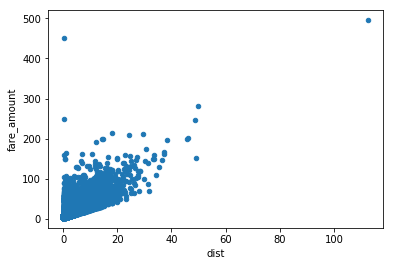

In [23]:
clean_data.plot(kind='scatter', x='dist', y='fare_amount')

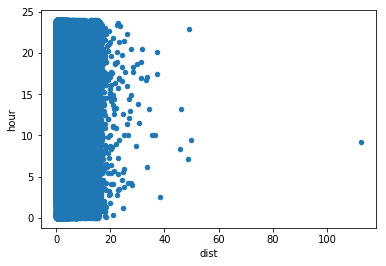

In [24]:
clean_data.plot(kind='scatter', x='dist', y='hour')

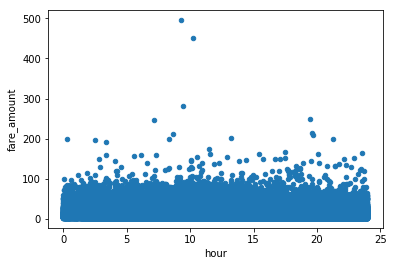

In [25]:
clean_data.plot(kind='scatter', x='hour', y='fare_amount')

# Simple Linear Regression Model

In [26]:
train, test = train_test_split(clean_data, test_size=0.3)

In [27]:
train_x = list(map(lambda x: [x], list(train.dist)))
train_y = list(map(lambda x: [x], list(train.fare_amount)))
test_x = list(map(lambda x: [x], list(test.dist)))
test_y = list(map(lambda x: [x], list(test.fare_amount)))

Coefficients: 
 [[3.52019501]]
Mean squared error: 21.50
Variance score: 0.76


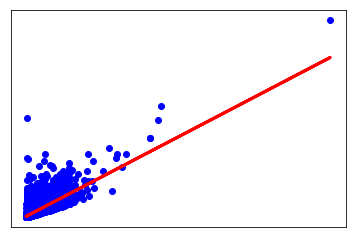

In [28]:
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
fare_predict = regr.predict(test_x)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test_y, fare_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_y, fare_predict))

# Plot outputs
plt.scatter(test_x, test_y,  color='blue')
plt.plot(test_x, fare_predict, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

# Prediction Baseline

In [29]:
test_df_dist = test_df.apply(dist, axis=1)
test_df.insert(test_df.shape[1], 'dist', test_df_dist)

In [30]:
test_X = list(map(lambda x: [x], list(test_df.dist)))

In [31]:
fare_predict = regr.predict(test_X).round(decimals = 2)

In [32]:
submission = pd.DataFrame({'key': test_df.key,\
                           'fare_amount': fare_predict.ravel()},\
                          columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)


In [33]:
submission.shape

(9914, 2)

# Extra Features 
## By year
## By weekday
## By time_of_day (hour)

## Extra Features - Adjusted_Fare_Amount_By_Rules

In [34]:
print(min(clean_data.year), max(clean_data.year))

2008 2015


In [35]:
years_df = [None for _ in range(min(clean_data.year), max(clean_data.year) + 1)]
minimum_year = min(clean_data.year)

years = max(clean_data.year) + 1 - minimum_year
for year in range(years):
    years_df[year] = clean_data[clean_data.year == minimum_year+year]
      
    train, test = train_test_split(years_df[year], test_size=0.2)
    train_x = list(map(lambda x: [x], list(train.dist)))
    train_y = list(map(lambda x: [x], list(train.fare_amount)))
    test_x = list(map(lambda x: [x], list(test.dist)))
    test_y = list(map(lambda x: [x], list(test.fare_amount)))
    regr.fit(train_x, train_y)
    fare_predict = regr.predict(test_x)

    print(years_df[year]['dist'].corr(years_df[year]['fare_amount']))
    # The coefficients
    print('Year: {}'.format(minimum_year + year), 'Coeff: ', regr.coef_, \
          "M.S.E: %.2f" % (mean_squared_error(test_y, fare_predict)), \
          'Variance score: %.2f' % r2_score(test_y, fare_predict))
    print('\n')

    # Plot outputs
#     plt.scatter(test_x, test_y,  color='blue')
#     plt.plot(test_x, fare_predict, color='red', linewidth=3)

#     plt.xticks(())
#     plt.yticks(())

    
# plt.show()

0.5440175917125062
Year: 2008 Coeff:  [[5.3698988]] M.S.E: 64.69 Variance score: -2.07


0.8918896761199503
Year: 2009 Coeff:  [[3.18882783]] M.S.E: 11.45 Variance score: 0.80


0.8601782011038539
Year: 2010 Coeff:  [[3.15564428]] M.S.E: 17.38 Variance score: 0.74


0.8884541194156172
Year: 2011 Coeff:  [[3.20860252]] M.S.E: 15.66 Variance score: 0.79


0.8595236315309722
Year: 2012 Coeff:  [[3.44157278]] M.S.E: 20.68 Variance score: 0.76


0.8895262686213044
Year: 2013 Coeff:  [[3.83650571]] M.S.E: 23.11 Variance score: 0.79


0.884422692672872
Year: 2014 Coeff:  [[3.85648295]] M.S.E: 24.76 Variance score: 0.79


0.8944291254568368
Year: 2015 Coeff:  [[3.93921538]] M.S.E: 28.83 Variance score: 0.76




# Night Surcharge

In [36]:
def night_surcharge(row_data, night = True):
    if night:
        return (row_data['hour'] >= 20) | (row_data['hour'] <= 6)
    else:
        return (row_data['hour'] < 20) & (row_data['hour'] > 6)
    
def weekday_filter(row_data):
    return row_data.weekday < 5 


In [37]:
for year in range(years):
    night = None
    night = years_df[year][night_surcharge(years_df[year], True)]
    train, test = train_test_split(night, test_size=0.2)
    train_x = list(map(lambda x: [x], list(train.dist)))
    train_y = list(map(lambda x: [x], list(train.fare_amount)))
    test_x = list(map(lambda x: [x], list(test.dist)))
    test_y = list(map(lambda x: [x], list(test.fare_amount)))
    regr.fit(train_x, train_y)
    fare_predict = regr.predict(test_x)

    print(night['dist'].corr(night['fare_amount']))
    # The coefficients
    print('Year: {}'.format(minimum_year + year), 'Coeff: ', regr.coef_, \
          "M.S.E: %.2f" % (mean_squared_error(test_y, fare_predict)), \
          'Variance score: %.2f' % r2_score(test_y, fare_predict))
    print('\n')

    # Plot outputs
#     plt.scatter(test_x, test_y,  color='blue')
#     plt.plot(test_x, fare_predict, color='red', linewidth=3)

#     plt.xticks(())
#     plt.yticks(())

    
# plt.show()

0.542135913467596
Year: 2008 Coeff:  [[2.86729547]] M.S.E: 10.95 Variance score: 0.44


0.8872102464924284
Year: 2009 Coeff:  [[3.11149594]] M.S.E: 11.71 Variance score: 0.80


0.8524869753433372
Year: 2010 Coeff:  [[3.15196572]] M.S.E: 18.45 Variance score: 0.73


0.8843341121672379
Year: 2011 Coeff:  [[3.15580758]] M.S.E: 16.12 Variance score: 0.78


0.8703604999801482
Year: 2012 Coeff:  [[3.33692831]] M.S.E: 25.48 Variance score: 0.74


0.8811627248581781
Year: 2013 Coeff:  [[3.78986074]] M.S.E: 26.36 Variance score: 0.75


0.8788998975630329
Year: 2014 Coeff:  [[3.80991107]] M.S.E: 24.99 Variance score: 0.79


0.8848932434862314
Year: 2015 Coeff:  [[3.85896129]] M.S.E: 35.56 Variance score: 0.76




0.5440175917125062
Year: 2008 Coeff:  [[2.75883281]] M.S.E: 7.13 Variance score: 0.52




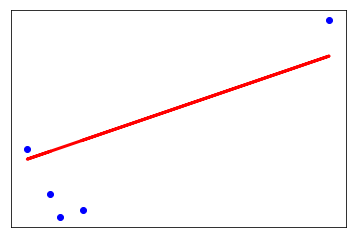

0.8938275457340299
Year: 2009 Coeff:  [[3.21543785]] M.S.E: 12.37 Variance score: 0.80




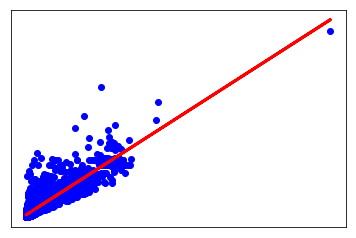

0.8616660993987024
Year: 2010 Coeff:  [[3.19551558]] M.S.E: 16.49 Variance score: 0.75




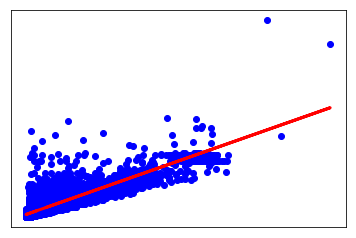

0.8892611710700099
Year: 2011 Coeff:  [[3.23602683]] M.S.E: 14.16 Variance score: 0.79




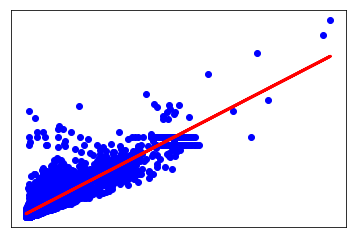

0.8720894709803355
Year: 2012 Coeff:  [[3.44845788]] M.S.E: 17.24 Variance score: 0.78




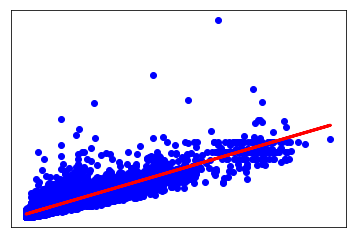

0.8913785020081447
Year: 2013 Coeff:  [[3.8492427]] M.S.E: 22.38 Variance score: 0.81




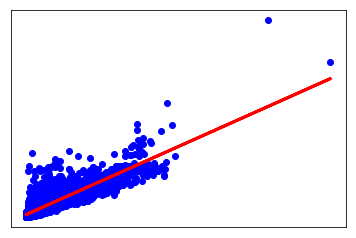

0.8837445219064569
Year: 2014 Coeff:  [[3.88371708]] M.S.E: 24.06 Variance score: 0.79




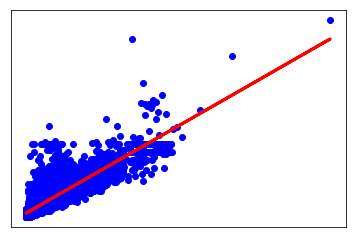

0.895719601736597
Year: 2015 Coeff:  [[3.97407629]] M.S.E: 25.55 Variance score: 0.80




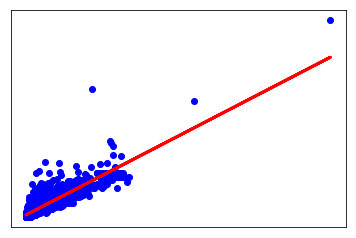

In [38]:
for year in range(years):
    flag = [True, False]
    weekday = None
    weekday = years_df[year][weekday_filter(years_df[year])]
    train, test = train_test_split(weekday, test_size=0.2)
    train_x = list(map(lambda x: [x], list(train.dist)))
    train_y = list(map(lambda x: [x], list(train.fare_amount)))
    test_x = list(map(lambda x: [x], list(test.dist)))
    test_y = list(map(lambda x: [x], list(test.fare_amount)))
    regr.fit(train_x, train_y)
    fare_predict = regr.predict(test_x)

    print(weekday['dist'].corr(weekday['fare_amount']))
    # The coefficients
    print('Year: {}'.format(minimum_year + year), 'Coeff: ', regr.coef_, \
          "M.S.E: %.2f" % (mean_squared_error(test_y, fare_predict)), \
          'Variance score: %.2f' % r2_score(test_y, fare_predict))
    print('\n')

    # Plot outputs
    plt.scatter(test_x, test_y,  color='blue')
    plt.plot(test_x, fare_predict, color='red', linewidth=3)

    plt.xticks(())
    plt.yticks(())

    
    plt.show()

# Taxicab Rate of Fare
## Airport Trips
```
* To & From LaGuardia Airport:

This is a metered fare. See Metered Fare information above.
* To/From JFK and any location in Manhattan:

Onscreen rate is ‘Rate 02 – JFK Airport.’
This is a flat fare of $52 plus tolls, the 50-cent MTA State Surcharge, the 30-cent Improvement Surcharge, and $4.50 rush hour surcharge (4 PM to 8 PM weekdays, excluding legal holidays).
Passenger is responsible for paying all tolls.
Please tip your driver for safety and good service.
* From JFK to other New York City destinations:

This is a metered fare. See Metered Fare information above.
* To Newark Airport:

Onscreen rate is ‘Rate 03 – Newark Airport.’
This is a metered fare. See Metered Fare information above.
There is a $17.50 Newark Surcharge.
Passenger is responsible for paying all roundtrip tolls.
There is a 30-cent Improvement Surcharge. 
Please tip your driver for safety and good service.
```

# Reference
[1] https://www1.nyc.gov/nyc-resources/service/1271/yellow-taxi-fares

You can get information about rates and fares for yellow cabs.

Upon entering the taxi, you will be charged the standard City fare rate of $3.30, which includes a 50-cent State surcharge and a 30-cent Improvement surcharge.

Additional charges also apply:

50 cents for every fifth of a mile
50 cents for every minute the taxi traveled less than 12 miles per hour
50 cents night surcharge for travel from 8 PM to 6 AM
$1 for travel from 4 PM to 8 PM on weekdays only
Travel to local airports and trips outside the City are charged different rates.

You can pay by credit or debit cards in yellow taxis with no extra charge.

[2] https://www.codevscolor.com/date-valid-check-python/

[3] https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html

[4] http://stamfordresearch.com/linear-regression-using-pandas-python/

# Experiments

In [39]:
# default_df = pd.read_csv(path, \
#                          names = ['key', 'fare_amount', 'pickup_datetime', \
#                                   'pickup_longitude', 'pickup_latitude', \
#                                   'dropoff_longitude', 'dropoff_latitude', \
#                                   'passenger_count'], \
#                          skiprows = 1, \
#                          nrows = 100)

In [40]:
# parsed_date_df = pd.read_csv(path, \
#                              names = ['key', 'fare_amount', 'pickup_datetime', \
#                                       'pickup_longitude', 'pickup_latitude', \
#                                       'dropoff_longitude', 'dropoff_latitude', \
#                                       'passenger_count'], \
#                              parse_dates = ['pickup_datetime'], \
#                              #converters={'pickup_datetime':datetime_parser},\
#                              skiprows = 1, \
#                              nrows = 100)

In [41]:
# print(type(default_df['pickup_datetime'][0]))
# print(type(parsed_date_df['pickup_datetime'][0]))

In [42]:
# test1 = pd.read_csv(path)

In [43]:
# test1.shape[0]
# 55423856

In [44]:
# test2 = pd.read_csv(path, parse_dates = ['pickup_datetime'])

In [45]:
# test2.shape[0]

In [46]:
# test2.to_csv('./all/train_data_with_parsed_time.csv')

In [47]:
# raw_data = pd.read_csv(path, parse_dates = ['pickup_datetime'], converters = {'pickup_datetime': datetime_parser})

In [48]:
# data['year'] = pd.DatetimeIndex(data['pickup_datetime']).year
# data['month'] = pd.DatetimeIndex(data['pickup_datetime']).month
# data['day'] = pd.DatetimeIndex(data['pickup_datetime']).day
# data['hour'] = pd.DatetimeIndex(data['pickup_datetime']).hour
# data['minute'] = pd.DatetimeIndex(data['pickup_datetime']).minute
# data['second'] = pd.DatetimeIndex(data['pickup_datetime']).second

In [49]:
# remove invalid pickup_datetime data
# data_t = raw_data[raw_data['pickup_datetime'] != pd.NaT]

In [50]:
# remove invalid fare_amount (soft rule: fare_amount should greater than 0)
# data_fare = data_t[data_t['fare_amount'] > 0]

In [51]:
# remove invalid longitude(longitude range from 0 ~ -180)
# data_longitude = data_fare[(data_fare['pickup_longitude'] < 0) & \
#                            (data_fare['pickup_longitude'] > -180) & \
#                            (data_fare['dropoff_longitude'] < 0) & \
#                            (data_fare['dropoff_longitude'] > -180)]

In [52]:
# remove invalid latitude (latitude range from 0 ~ 90)
# data_latitude = data_longitude[(data_longitude['pickup_latitude'] > 0) & \
#                                (data_longitude['pickup_latitude'] < 90) & \
#                                (data_longitude['dropoff_latitude'] > 0) & \
#                                (data_longitude['dropoff_latitude'] < 90)]

In [53]:
# print('raw data:', raw_data.shape[0])
# print('remove invalid pickup_datetime data:', data_t.shape[0])
# print('remove fare_amount <= 0 data:', data_fare.shape[0])
# print('remove invalid longitude data:', data_longitude.shape[0])
# print('remove invalid latitude data:', data_latitude.shape[0])